# Connectivity Data Analysis with Study Class

This notebook covers:
- Loading study data
- Running regression models
- Creating specification curves

## 1. Loading the Data

First, we'll import the Study class and load both the unmerged and merged datasets.

In [2]:
from statistical_model import Study
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define frequency band order (from data_preparation.py)
FREQUENCY_BAND_ORDER = ["delta", "theta", "alpha", "beta", "gamma"]

# Load unmerged and merged study datasets
study = Study.load("study_merged_1000.cdb")
study2 = Study.load("study_unmerged_1000.cdb")

Study loaded successfully from study_merged_1000.cdb
Study loaded successfully from study_unmerged_1000.cdb


## 2. Exploring the Data

Let's examine the basic properties of both datasets using the `summary()` method.

In [3]:
print("Unmerged study summary:")
study.summary()

Unmerged study summary:
Study summary: 4620 measurements loaded

Nodes by label:
CEN:
       L-ITG, L-SFG, L-SUP, L-pSTG, R-IFG, R-ITG, R-SFG, R-SUP, R-pSTG
DMN:
       L-ANG, L-IFG, L-PREC, L-aSTG, L-mPFC, R-ANG, R-PREC, R-aSTG, R-mPFC
SN:
       L-ACC, L-INS, R-ACC, R-INS

Measurement conditions:
  bands: alpha, beta, delta, gamma, theta
  city: merged(Kraków,Warszawa)
  eyes: eyes closed, eyes open

Samples:
  Sample ID: merged_sample, Subjects: 107

Permutation Statistics:
  Original Mean Contrast: 0.0216
  Original Median Contrast: 0.0196
  Mean Contrast p-value: 0.2460
  Median Contrast p-value: 0.3130
  Mean Contrast 95% CI: [-0.0331, 0.0340]
  Median Contrast 95% CI: [-0.0359, 0.0370]
  Number of permutations: 1000


In [4]:
print("\nMerged study summary:")
study2.summary()


Merged study summary:
Study summary: 9240 measurements loaded

Nodes by label:
CEN:
       L-ITG, L-SFG, L-SUP, L-pSTG, R-IFG, R-ITG, R-SFG, R-SUP, R-pSTG
DMN:
       L-ANG, L-IFG, L-PREC, L-aSTG, L-mPFC, R-ANG, R-PREC, R-aSTG, R-mPFC
SN:
       L-ACC, L-INS, R-ACC, R-INS

Measurement conditions:
  bands: alpha, beta, delta, gamma, theta
  city: Kraków, Warszawa
  eyes: eyes closed, eyes open

Samples:
  Sample ID: city_Kraków, Subjects: 40
  Sample ID: city_Warszawa, Subjects: 67

Permutation Statistics:
  Original Mean Contrast: 0.0229
  Original Median Contrast: 0.0200
  Mean Contrast p-value: 0.1820
  Median Contrast p-value: 0.2590
  Mean Contrast 95% CI: [-0.0315, 0.0353]
  Median Contrast 95% CI: [-0.0320, 0.0353]
  Number of permutations: 1000


## 3. Regression Analysis

Now let's run regression models on our data. We'll try different formulations and compare the results.

### Model 1: (Merged Data)

Calculating permutation-based statistics...
Regression Analysis Results (APA Format)
----------------------------------------
Model: contrast ~ city + eyes + network_relation+bands+ network_relation:bands

The regression model explained 0.164 of the variance, F = 19.904, p = 0.219
Note: p-values are permutation-based (permuted group)

Contrast Statistics:
Mean Contrast: 0.022, 95% CI [-0.033, 0.034], p = 0.246
Median Contrast: 0.020, 95% CI [-0.036, 0.037], p = 0.313

Regression Coefficients:
Parameter            Estimate   SE         t          p         
-------------------- ---------- ---------- ---------- ----------
Intercept            -0.006     0.026      -0.771     0.841      [-0.057, 0.044]     
eyes open            -0.010     0.011      -3.505     0.383      [-0.031, 0.011]     
CEN→DMN              0.040      0.022      3.607      0.078   .  [-0.003, 0.084]     
CEN→SN               0.068      0.044      4.809      0.130      [-0.018, 0.153]     
DMN→CEN              -0.042 

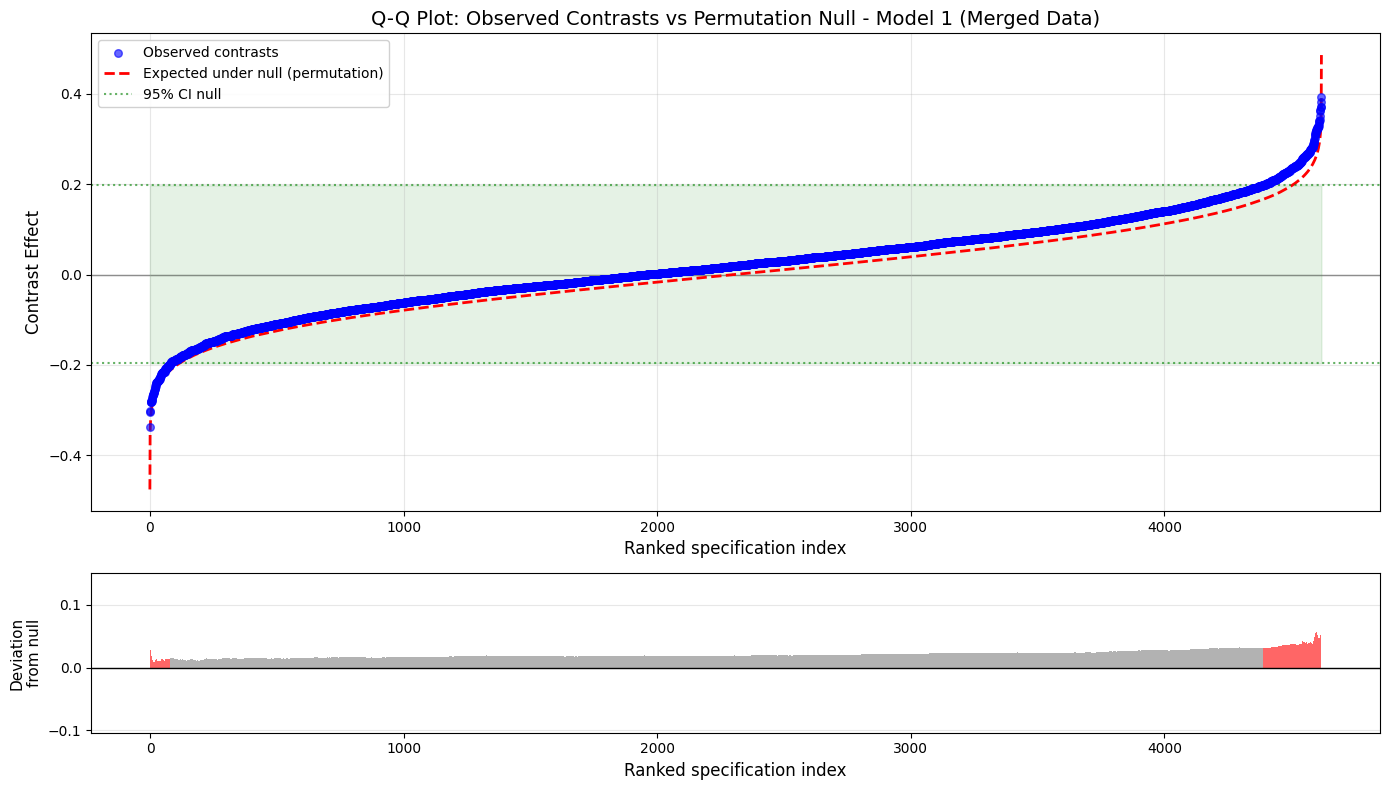


Model 1 Contrast Q-Q Plot Summary:
  Total specifications: 4620
  Outside 95% CI: 314 (6.8%)
  Expected outside 95% CI: ~231
  Mean contrast: 0.0216
  Null mean: 0.0005
  Mean absolute deviation: 0.0211


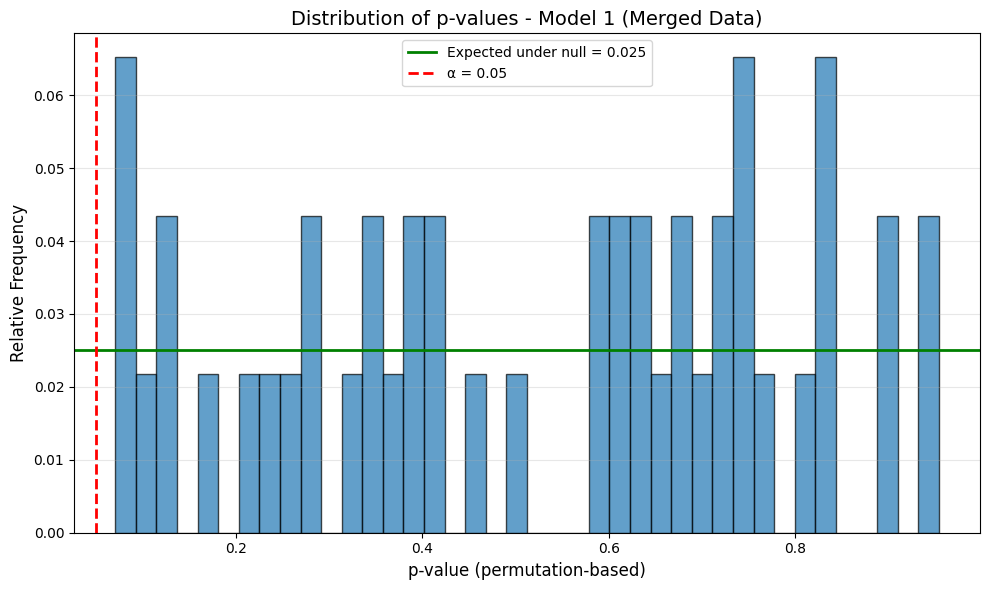


Model 1: 46 parameters, 0 significant at α=0.05


In [ ]:
# Model using band, city, eyes and network relation in unmerged data
model1_results = study.regression(
    "~ city + eyes + network_relation+bands+ network_relation:bands",
    add_network_categories=True,
    n_permutations=1000,
    band_order=FREQUENCY_BAND_ORDER
)

print(study.print_apa_format(model1_results))

# Horizontal Q-Q plot of contrasts vs permutation null distribution for Model 1
spec_df_1, results_df_1 = study.specification_data(add_network_categories=True)
if len(results_df_1) > 0 and hasattr(study, 'permuted_results') and study.permuted_results:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Get observed contrasts (sorted)
    observed_contrasts = results_df_1['contrast'].values
    observed_sorted = np.sort(observed_contrasts)
    n_obs = len(observed_sorted)

    # Build null distribution from all permutation results
    all_perm_contrasts = []
    for perm_result in study.permuted_results:
        all_perm_contrasts.extend(perm_result.values())
    all_perm_contrasts = np.array(all_perm_contrasts)

    # Calculate expected quantiles from null distribution
    quantile_positions = np.linspace(0, 1, n_obs)
    expected_quantiles = np.quantile(all_perm_contrasts, quantile_positions)

    # Top panel: Q-Q plot (specification curve style)
    x_pos = np.arange(n_obs)
    ax1.scatter(x_pos, observed_sorted, alpha=0.6, s=30, c='blue', label='Observed contrasts', zorder=3)
    ax1.plot(x_pos, expected_quantiles, 'r--', linewidth=2, label='Expected under null (permutation)', zorder=2)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5, zorder=1)

    # Add confidence bands (95% CI from permutations)
    lower_band = np.quantile(all_perm_contrasts, 0.025)
    upper_band = np.quantile(all_perm_contrasts, 0.975)
    ax1.axhline(y=lower_band, color='green', linestyle=':', linewidth=1.5, alpha=0.6, label='95% CI null')
    ax1.axhline(y=upper_band, color='green', linestyle=':', linewidth=1.5, alpha=0.6)
    ax1.fill_between(x_pos, lower_band, upper_band, alpha=0.1, color='green')

    ax1.set_ylabel('Contrast Effect', fontsize=12)
    ax1.set_xlabel('Ranked specification index', fontsize=12)
    ax1.set_title('Q-Q Plot: Observed Contrasts vs Permutation Null - Model 1 (Merged Data)', fontsize=14)
    ax1.legend(loc='upper left', framealpha=0.9)
    ax1.grid(True, alpha=0.3)

    # Bottom panel: Deviation from null expectation
    deviation = observed_sorted - expected_quantiles
    colors = ['red' if abs(obs) > upper_band else 'gray' for obs in observed_sorted]
    ax2.bar(x_pos, deviation, color=colors, alpha=0.6, width=1.0)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_ylabel('Deviation\nfrom null', fontsize=11)
    ax2.set_xlabel('Ranked specification index', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    n_extreme = np.sum((observed_sorted < lower_band) | (observed_sorted > upper_band))
    print(f"\nModel 1 Contrast Q-Q Plot Summary:")
    print(f"  Total specifications: {n_obs}")
    print(f"  Outside 95% CI: {n_extreme} ({100*n_extreme/n_obs:.1f}%)")
    print(f"  Expected outside 95% CI: ~{int(n_obs * 0.05)}")
    print(f"  Mean contrast: {np.mean(observed_sorted):.4f}")
    print(f"  Null mean: {np.mean(all_perm_contrasts):.4f}")
    print(f"  Mean absolute deviation: {np.mean(np.abs(deviation)):.4f}")




# Plot histogram of p-values for Model 1
if model1_results[1] is not None and 'p-value (perm)' in model1_results[1].columns:
    plt.figure(figsize=(10, 6))
    p_values = model1_results[1]['p-value (perm)'].dropna()
    n_bins = 40
    n_pvalues = len(p_values)

    # Calculate expected frequency under null hypothesis
    expected_freq = 1.0 / n_bins

    # Plot relative frequency histogram
    counts, bins, patches = plt.hist(p_values, bins=n_bins, edgecolor='black', alpha=0.7,
                                      density=False, weights=np.ones(n_pvalues) / n_pvalues)

    # Add horizontal line for expected frequency under null
    plt.axhline(y=expected_freq, color='green', linestyle='-', linewidth=2,
                label=f'Expected under null = {expected_freq:.3f}')

    plt.xlabel('p-value (permutation-based)', fontsize=12)
    plt.ylabel('Relative Frequency', fontsize=12)
    plt.title('Distribution of p-values - Model 1 (Merged Data)', fontsize=14)
    plt.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"\nModel 1: {n_pvalues} parameters, {np.sum(p_values < 0.05)} significant at α=0.05")

### Model 2: (Unmerged Data)

Calculating permutation-based statistics...
Regression Analysis Results (APA Format)
----------------------------------------
Model: contrast ~ eyes + network_relation+bands+ network_relation:bands

The regression model explained 0.054 of the variance, F = 11.600, p = 0.125
Note: p-values are permutation-based (permuted group)

Contrast Statistics:
Mean Contrast: 0.023, 95% CI [-0.031, 0.035], p = 0.182
Median Contrast: 0.020, 95% CI [-0.032, 0.035], p = 0.259

Regression Coefficients:
Parameter            Estimate   SE         t          p         
-------------------- ---------- ---------- ---------- ----------
Intercept            0.002      0.018      0.255      0.897      [-0.032, 0.037]     
eyes open            -0.009     0.011      -2.718     0.499      [-0.031, 0.013]     
CEN→DMN              0.040      0.019      3.058      0.062   .  [0.003, 0.077]      
CEN→SN               0.050      0.028      3.015      0.121      [-0.004, 0.104]     
DMN→CEN              -0.037     0.0

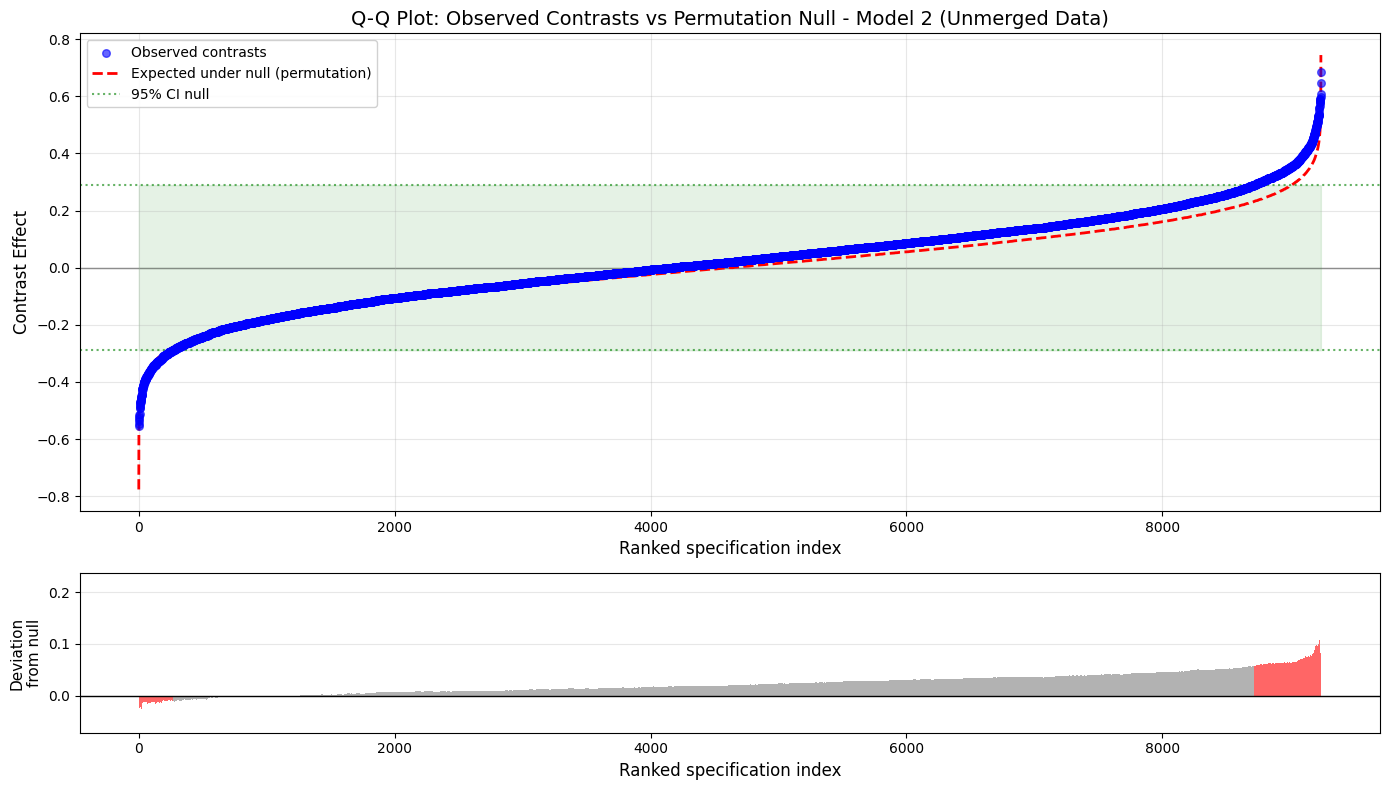


Model 2 Contrast Q-Q Plot Summary:
  Total specifications: 9240
  Outside 95% CI: 794 (8.6%)
  Expected outside 95% CI: ~462
  Mean contrast: 0.0229
  Null mean: 0.0002
  Mean absolute deviation: 0.0243


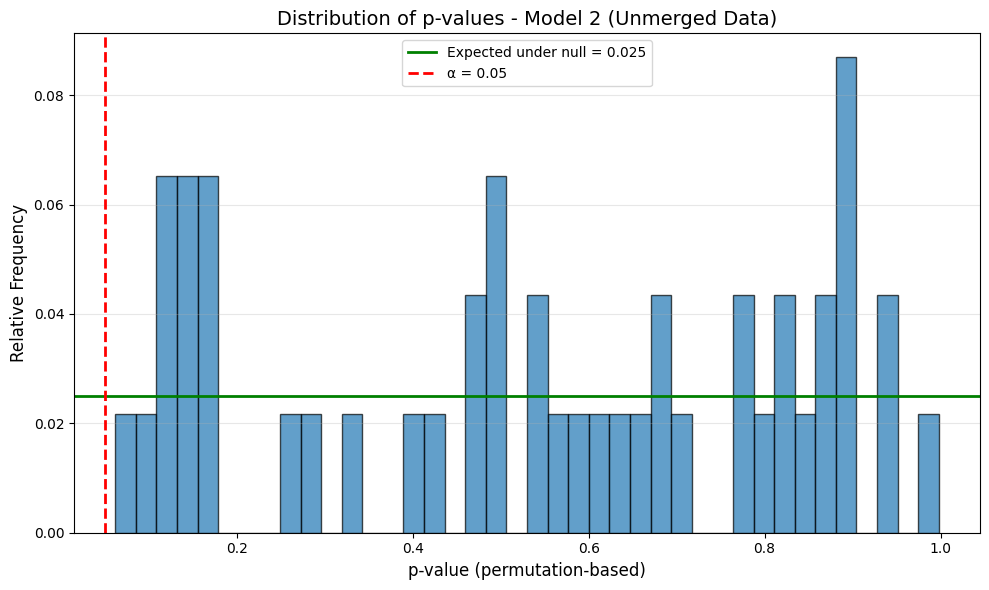


Model 2: 46 parameters, 0 significant at α=0.05


In [7]:
# Model with network relation and bands interaction in merged data
model2_results = study2.regression(
    "~ eyes + network_relation+bands+ network_relation:bands",
    add_network_categories=True,
    n_permutations=1000,
    band_order=FREQUENCY_BAND_ORDER
)

print(study2.print_apa_format(model2_results))

# Horizontal Q-Q plot of contrasts vs permutation null distribution for Model 2
spec_df_2, results_df_2 = study2.specification_data(add_network_categories=True)
if len(results_df_2) > 0 and hasattr(study2, 'permuted_results') and study2.permuted_results:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Get observed contrasts (sorted)
    observed_contrasts = results_df_2['contrast'].values
    observed_sorted = np.sort(observed_contrasts)
    n_obs = len(observed_sorted)

    # Build null distribution from all permutation results
    all_perm_contrasts = []
    for perm_result in study2.permuted_results:
        all_perm_contrasts.extend(perm_result.values())
    all_perm_contrasts = np.array(all_perm_contrasts)

    # Calculate expected quantiles from null distribution
    quantile_positions = np.linspace(0, 1, n_obs)
    expected_quantiles = np.quantile(all_perm_contrasts, quantile_positions)

    # Top panel: Q-Q plot (specification curve style)
    x_pos = np.arange(n_obs)
    ax1.scatter(x_pos, observed_sorted, alpha=0.6, s=30, c='blue', label='Observed contrasts', zorder=3)
    ax1.plot(x_pos, expected_quantiles, 'r--', linewidth=2, label='Expected under null (permutation)', zorder=2)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5, zorder=1)

    # Add confidence bands (95% CI from permutations)
    lower_band = np.quantile(all_perm_contrasts, 0.025)
    upper_band = np.quantile(all_perm_contrasts, 0.975)
    ax1.axhline(y=lower_band, color='green', linestyle=':', linewidth=1.5, alpha=0.6, label='95% CI null')
    ax1.axhline(y=upper_band, color='green', linestyle=':', linewidth=1.5, alpha=0.6)
    ax1.fill_between(x_pos, lower_band, upper_band, alpha=0.1, color='green')

    ax1.set_ylabel('Contrast Effect', fontsize=12)
    ax1.set_xlabel('Ranked specification index', fontsize=12)
    ax1.set_title('Q-Q Plot: Observed Contrasts vs Permutation Null - Model 2 (Unmerged Data)', fontsize=14)
    ax1.legend(loc='upper left', framealpha=0.9)
    ax1.grid(True, alpha=0.3)

    # Bottom panel: Deviation from null expectation
    deviation = observed_sorted - expected_quantiles
    colors = ['red' if abs(obs) > upper_band else 'gray' for obs in observed_sorted]
    ax2.bar(x_pos, deviation, color=colors, alpha=0.6, width=1.0)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_ylabel('Deviation\nfrom null', fontsize=11)
    ax2.set_xlabel('Ranked specification index', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('model2_contrast_qqplot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    n_extreme = np.sum((observed_sorted < lower_band) | (observed_sorted > upper_band))
    print(f"\nModel 2 Contrast Q-Q Plot Summary:")
    print(f"  Total specifications: {n_obs}")
    print(f"  Outside 95% CI: {n_extreme} ({100*n_extreme/n_obs:.1f}%)")
    print(f"  Expected outside 95% CI: ~{int(n_obs * 0.05)}")
    print(f"  Mean contrast: {np.mean(observed_sorted):.4f}")
    print(f"  Null mean: {np.mean(all_perm_contrasts):.4f}")
    print(f"  Mean absolute deviation: {np.mean(np.abs(deviation)):.4f}")


# Plot histogram of p-values for Model 2
if model2_results[1] is not None and 'p-value (perm)' in model2_results[1].columns:
    plt.figure(figsize=(10, 6))
    p_values = model2_results[1]['p-value (perm)'].dropna()
    n_bins = 40
    n_pvalues = len(p_values)

    # Calculate expected frequency under null hypothesis
    expected_freq = 1.0 / n_bins

    # Plot relative frequency histogram
    counts, bins, patches = plt.hist(p_values, bins=n_bins, edgecolor='black', alpha=0.7,
                                      density=False, weights=np.ones(n_pvalues) / n_pvalues)

    # Add horizontal line for expected frequency under null
    plt.axhline(y=expected_freq, color='green', linestyle='-', linewidth=2,
                label=f'Expected under null = {expected_freq:.3f}')

    plt.xlabel('p-value (permutation-based)', fontsize=12)
    plt.ylabel('Relative Frequency', fontsize=12)
    plt.title('Distribution of p-values - Model 2 (Unmerged Data)', fontsize=14)
    plt.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"\nModel 2: {n_pvalues} parameters, {np.sum(p_values < 0.05)} significant at α=0.05")

## 4. Specification Curve Analysis

Specification curve analysis allows us to visualize how results vary across different model specifications.

Specification curve for model1 with merged data...


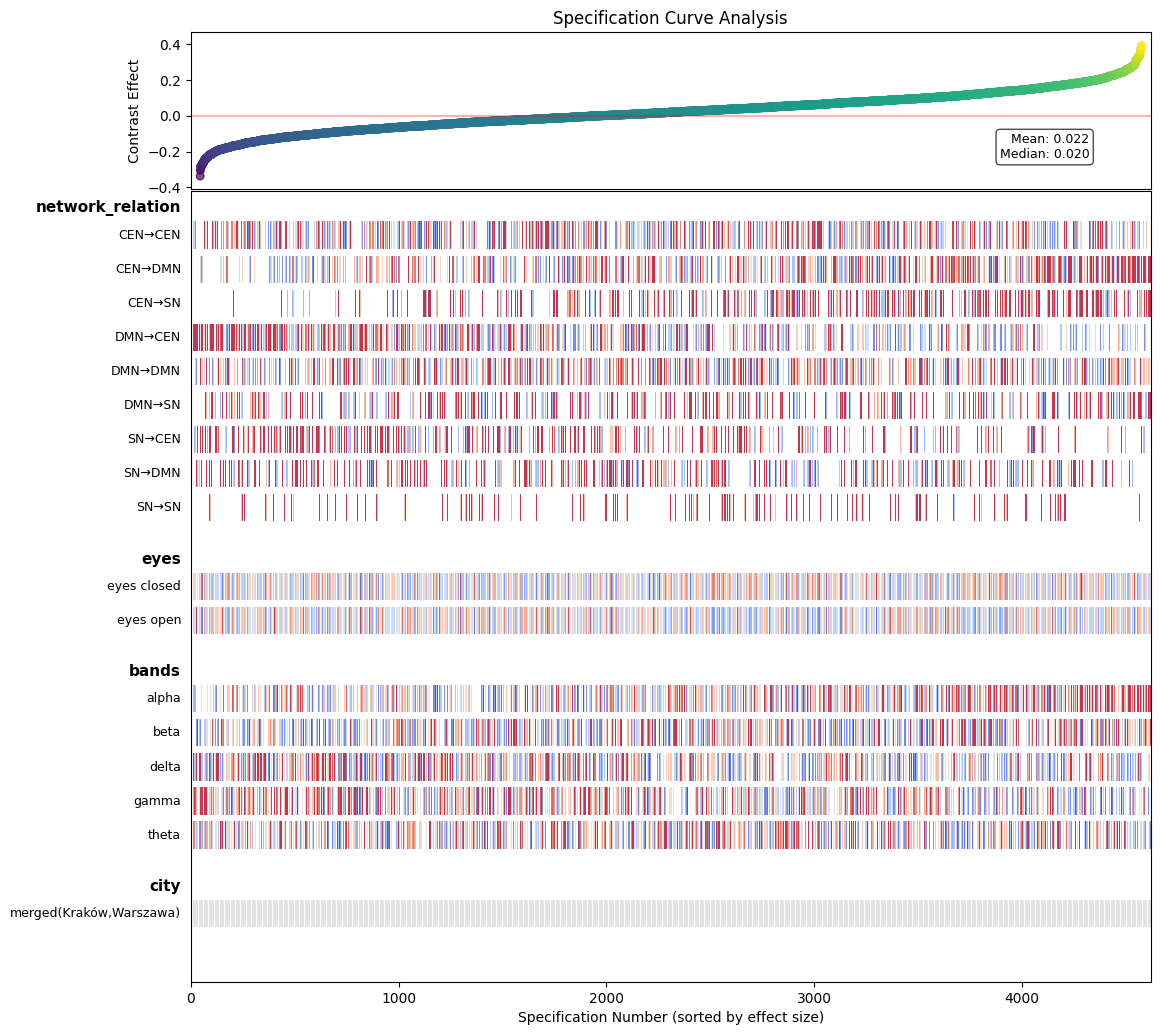

Specification curve for model2 with merged data...


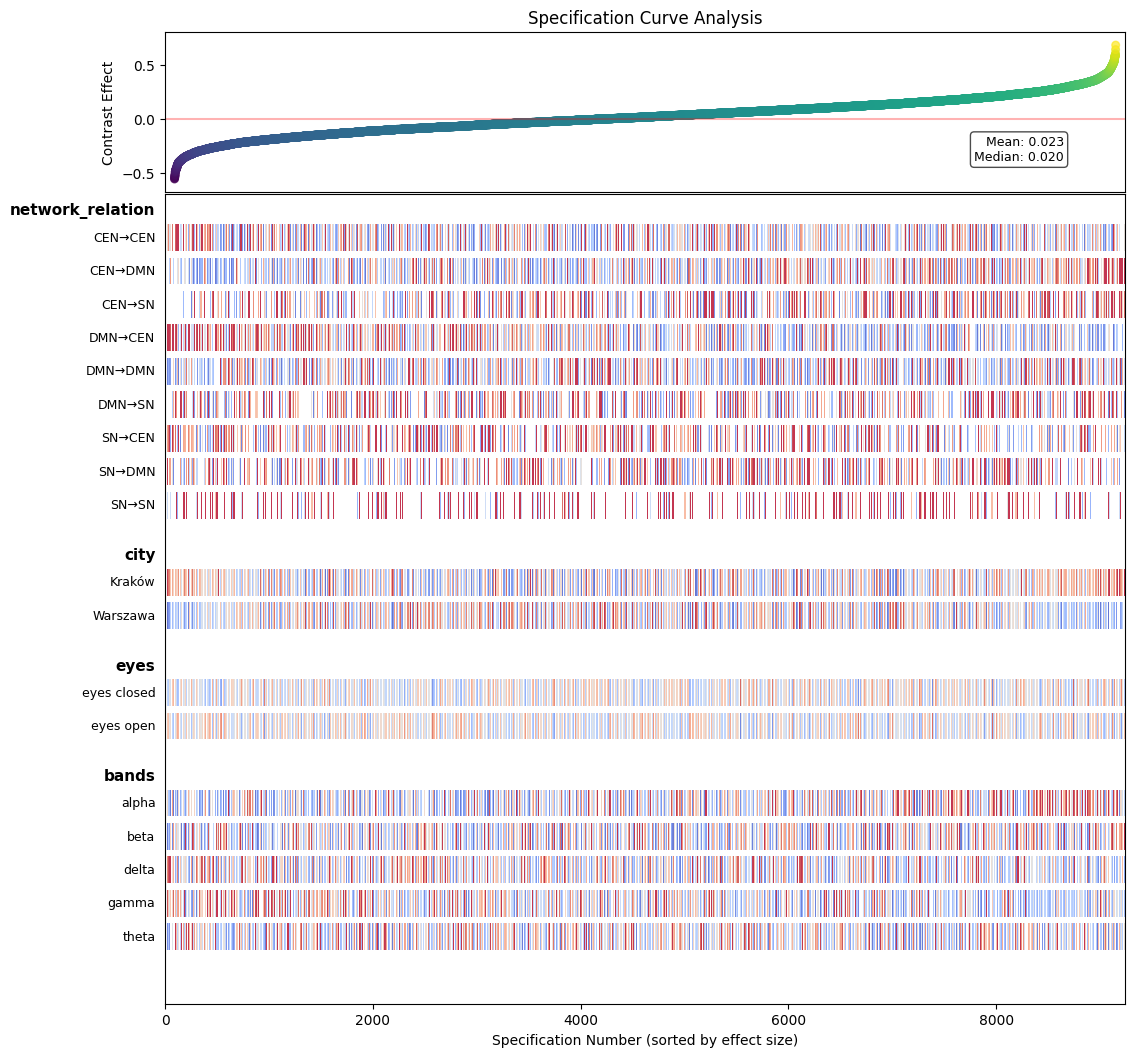

In [9]:
# Generate a specification curve with unmerged data
print("Specification curve for model1 with merged data...")
spec_df, results_df = study.specification_curve(add_network_categories=True, plot_type = 'density')

# Generate a specification curve with merged data
print("Specification curve for model2 with merged data...")
spec_df, results_df = study2.specification_curve(add_network_categories=True, plot_type = 'density')